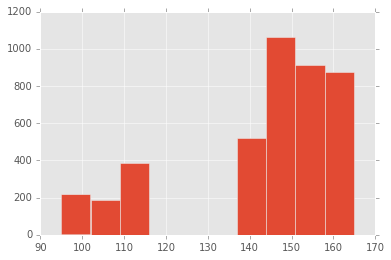

In [102]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
conn = sqlite3.connect("ss.db")
cur  = conn.cursor()

import time
import os

import pandas as pd

qry = """SELECT
bin_contents.BinNumber,
bin_contents.ID_Full,
bouncepoints_full.Event,
bouncepoints_full.Range,
bouncepoints_full.EvtDep,
snr.SNR
FROM bin_contents
LEFT JOIN bouncepoints_full 
ON bouncepoints_full.ID_Full=bin_contents.ID_Full
LEFT JOIN snr
ON bouncepoints_full.ID_Full=snr.ID_Full
WHERE bouncepoints_full.EvtDep < 75
AND (bouncepoints_full.Range > 95
AND bouncepoints_full.Range < 115)
OR (bouncepoints_full.Range > 140
AND bouncepoints_full.Range < 165)
ORDER BY bouncepoints_full.EvtDep
"""

dfds = pd.read_sql_query(qry, conn)

dfbins = pd.read_sql_query("SELECT * from bin_parameters", conn)
dfds.Range.hist()
plt.show()

In [103]:
def plot_location(bin_number):

    binparams = dfbins.query('index == %d' % bin_number)

    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap


    # Lambert Conformal Conic map.
    m = Basemap(llcrnrlon=-135.,llcrnrlat=0.,urcrnrlon=45.,urcrnrlat=61.,
                projection='lcc',lat_1=35.,lat_2=45.,lon_0=-100.,
                resolution ='l',area_thresh=1000.)
    names = []

    # draw coastlines, meridians and parallels.
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    m.drawparallels(np.arange(10,71,20),labels=[1,1,0,0])
    m.drawmeridians(np.arange(-180,0,20),labels=[0,0,0,1])

    x, y = m( np.array(binparams.Longitude), np.array(binparams.Latitude) )

    m.scatter(x, y, color='black', marker = 'o', s=1000, zorder = 10000)

    plt.title('Bin Location')

plt.style.use('ggplot')

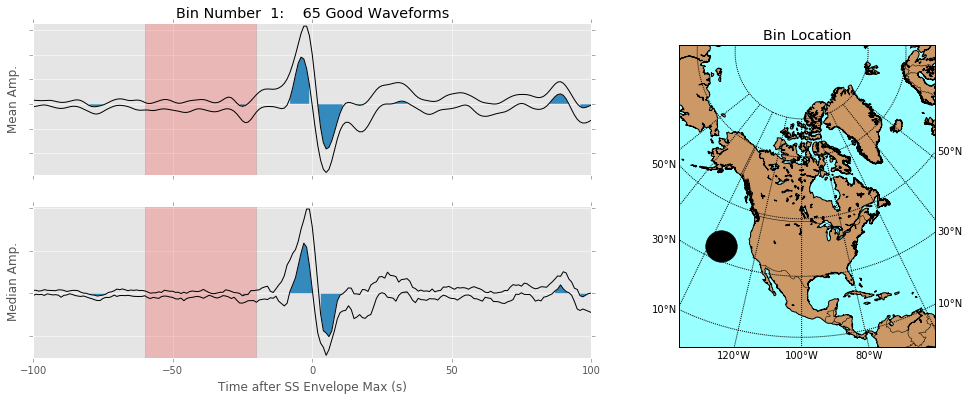

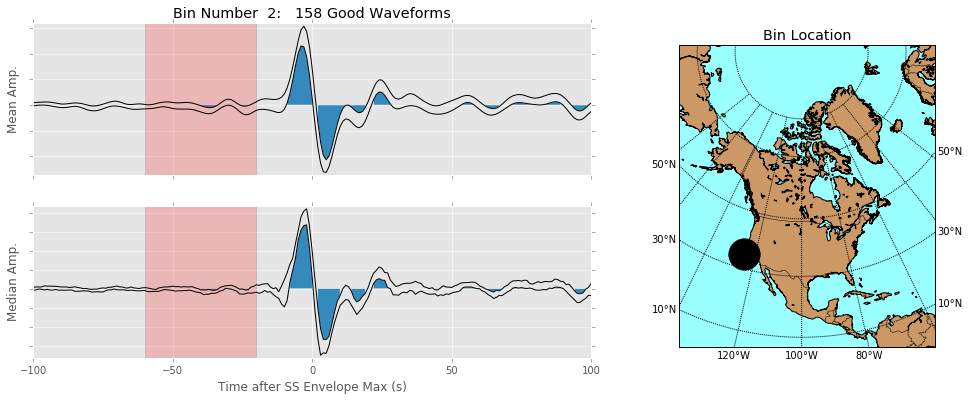

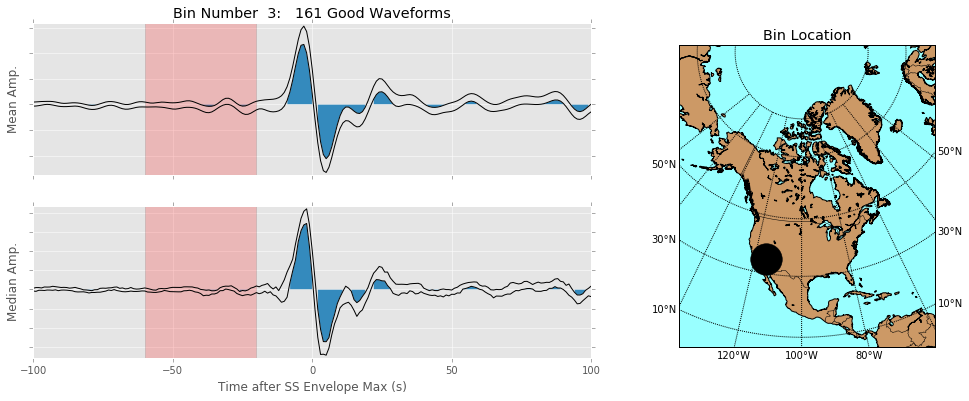

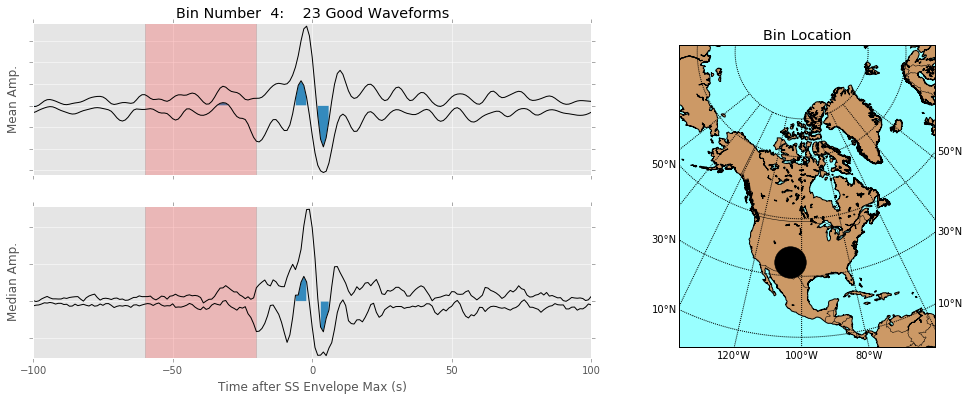

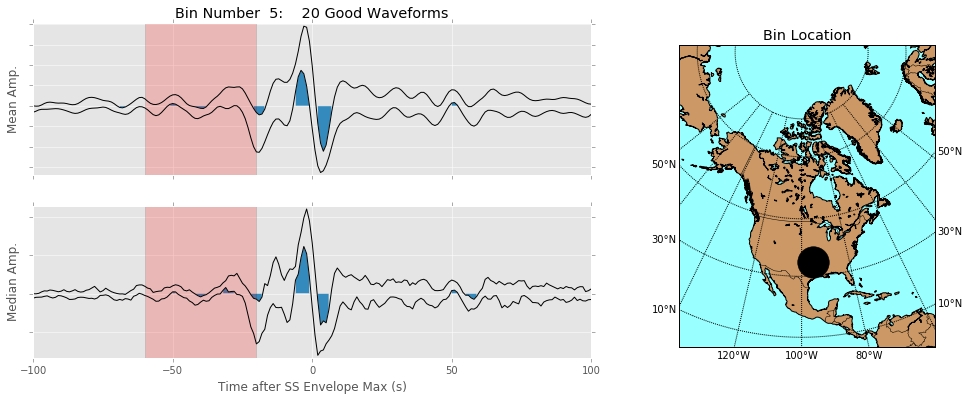

Skipping bin   6
Skipping bin   7
Skipping bin   8
Skipping bin   9


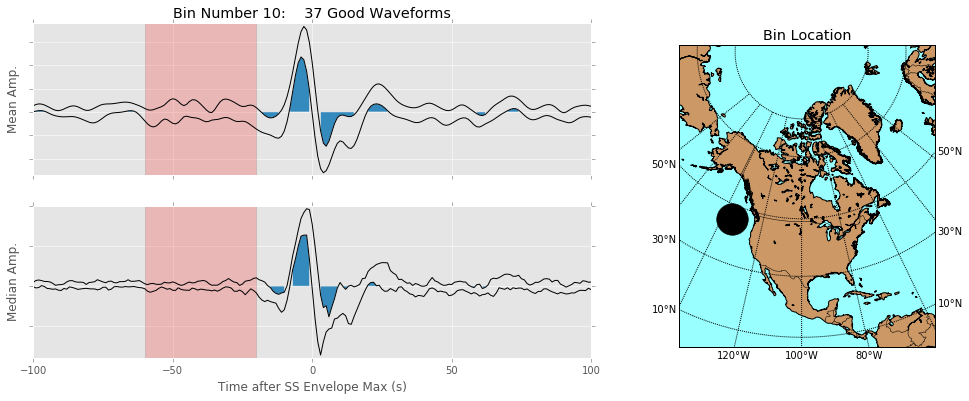

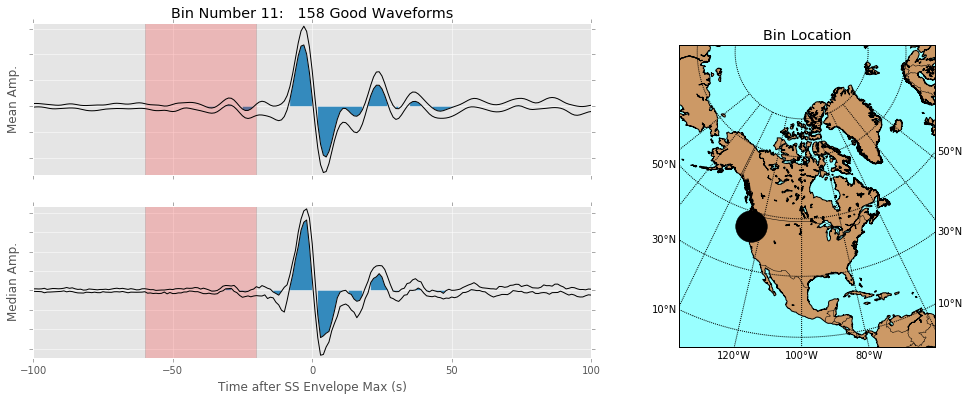

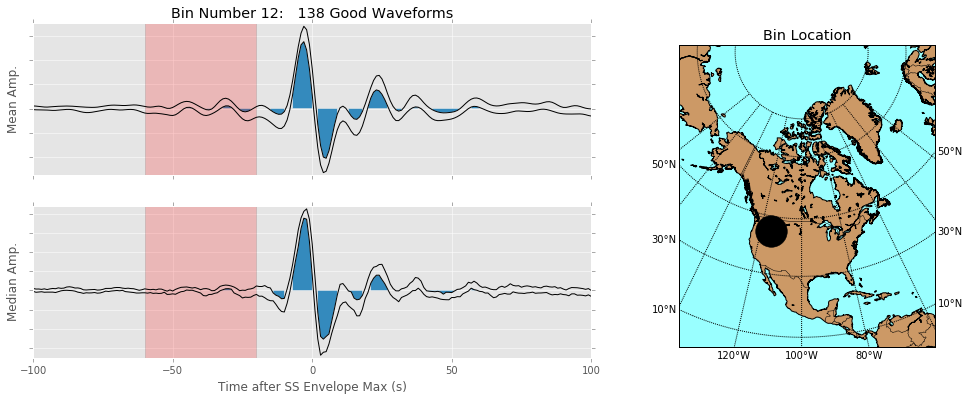

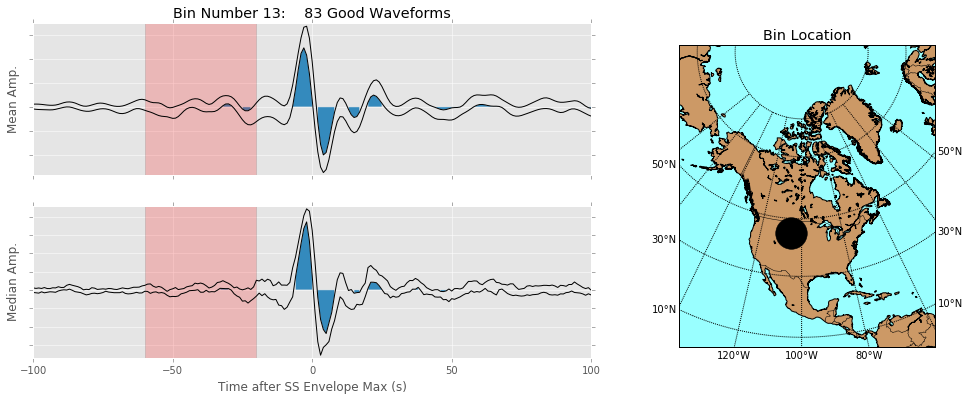

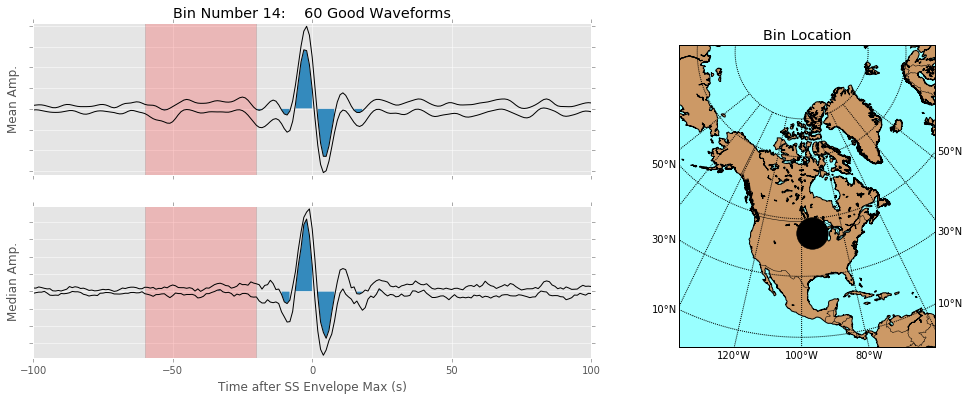

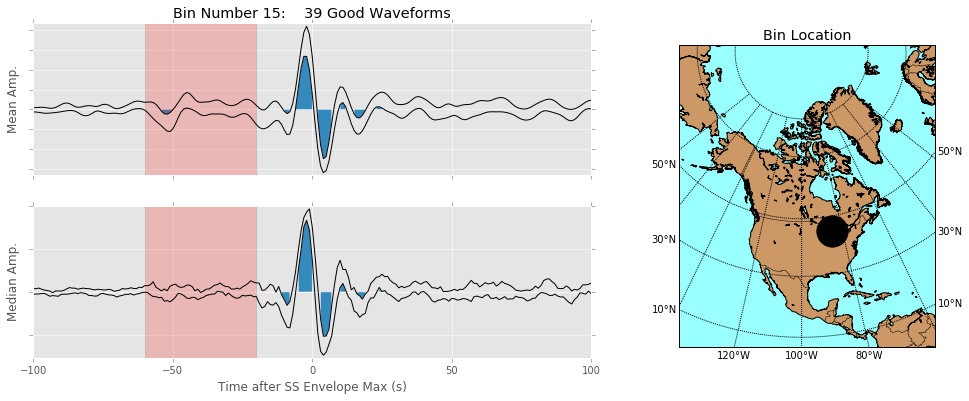

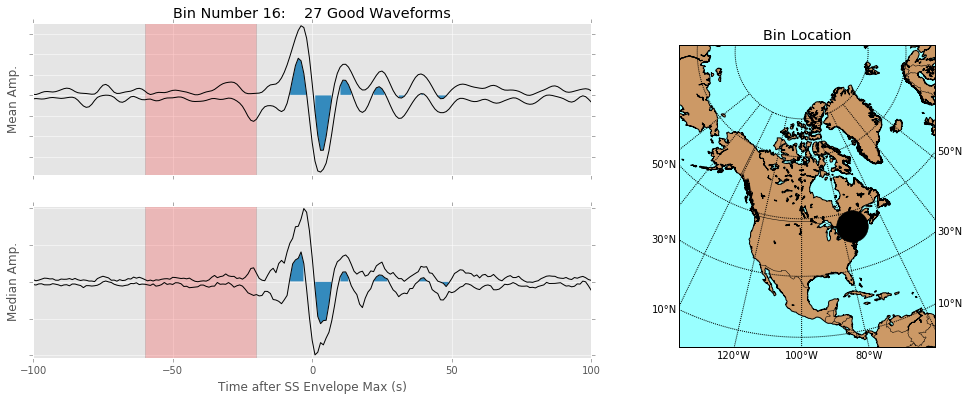

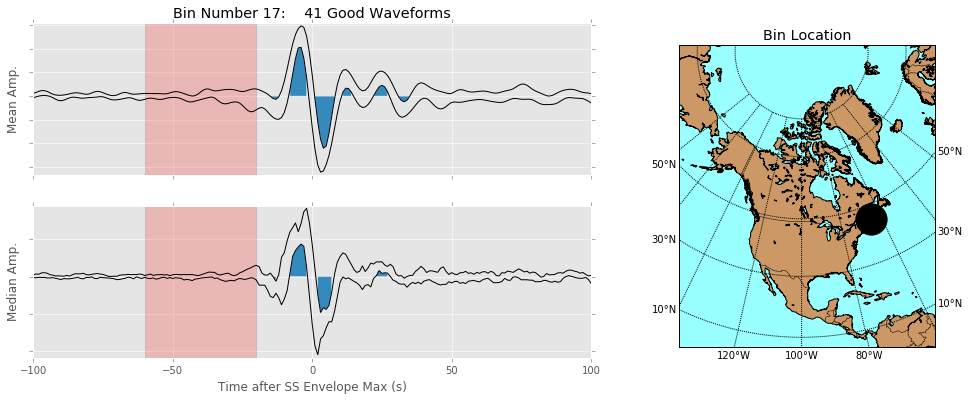

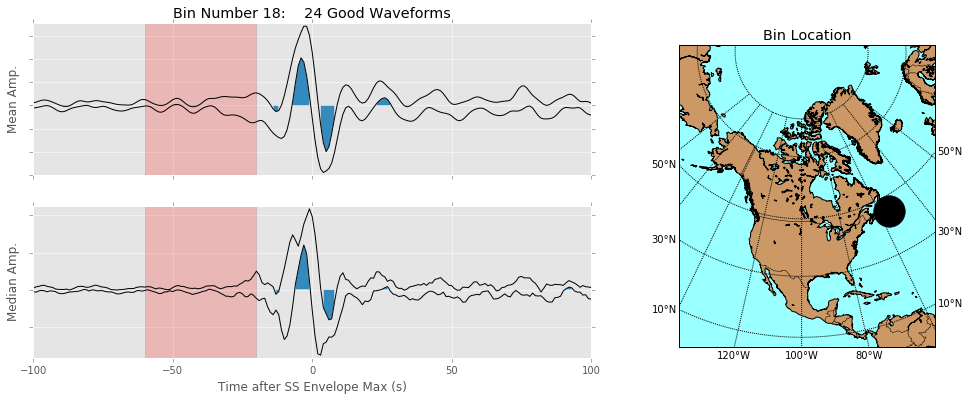

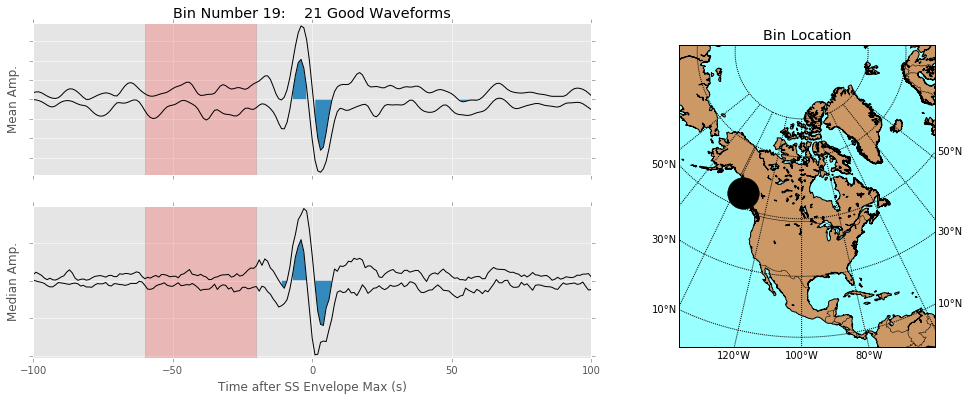

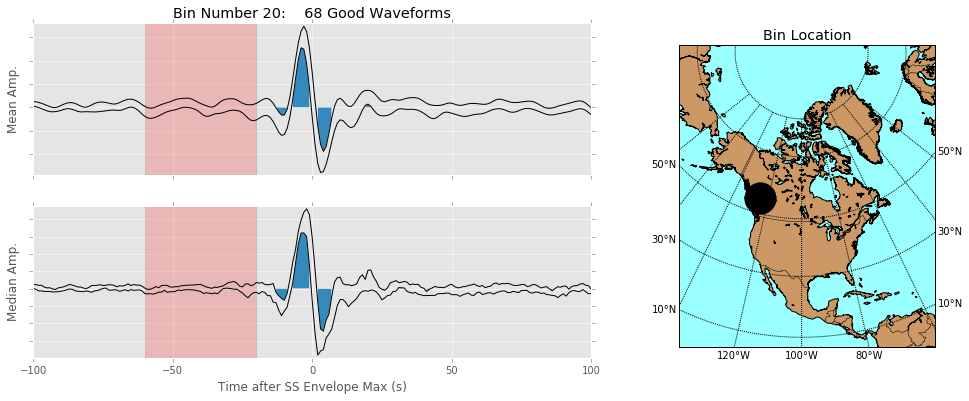

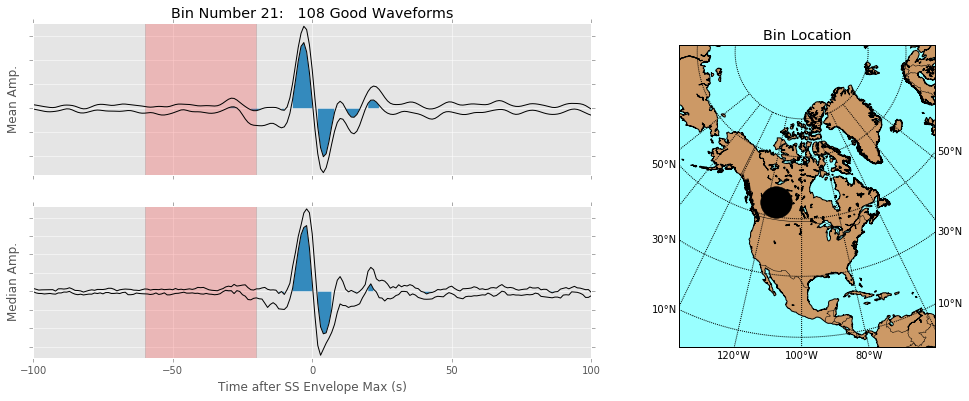

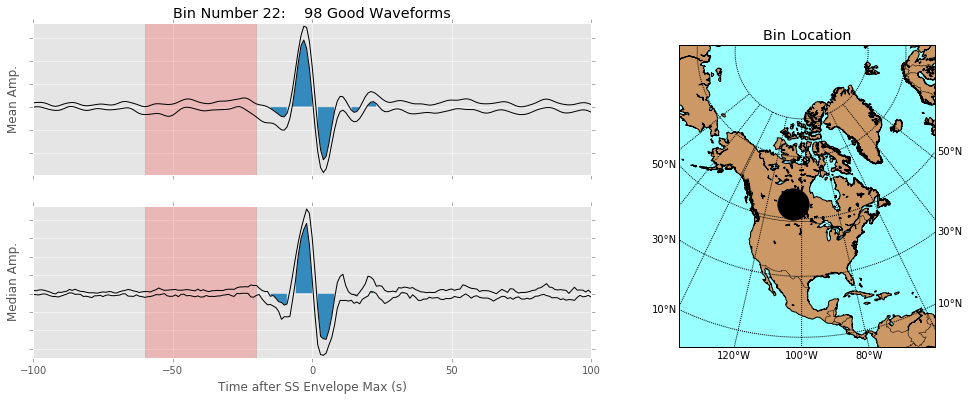

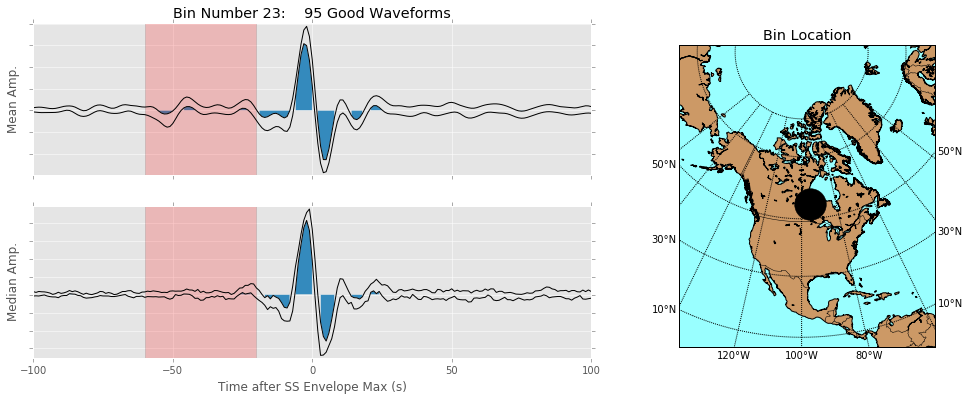

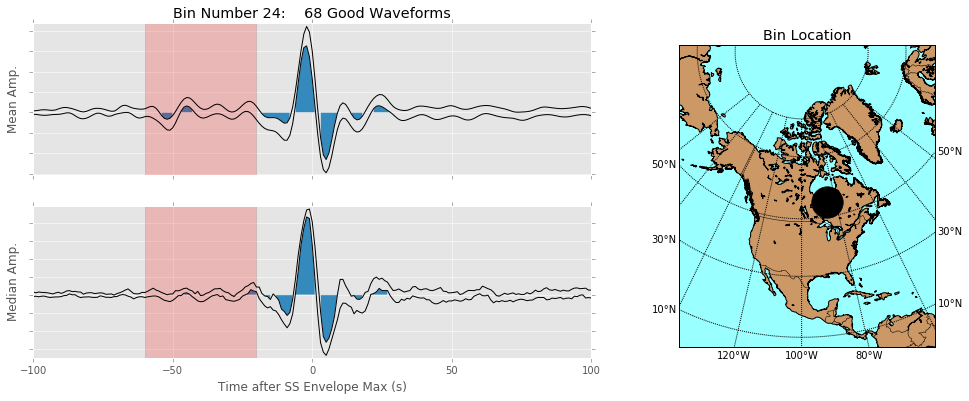

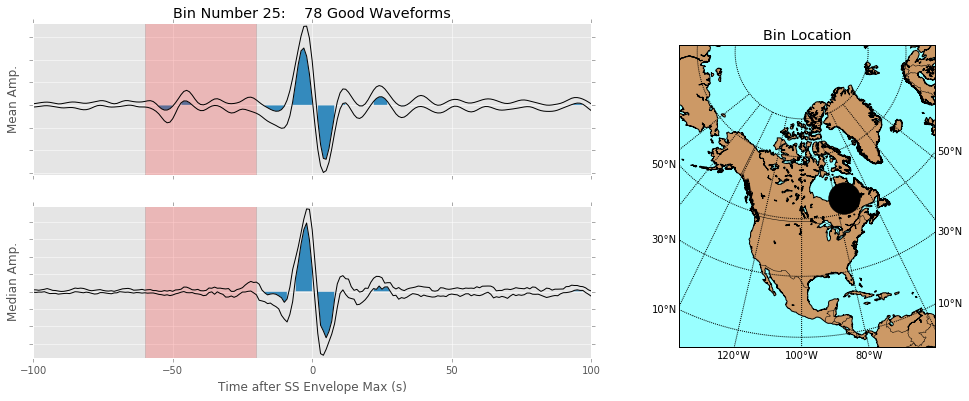

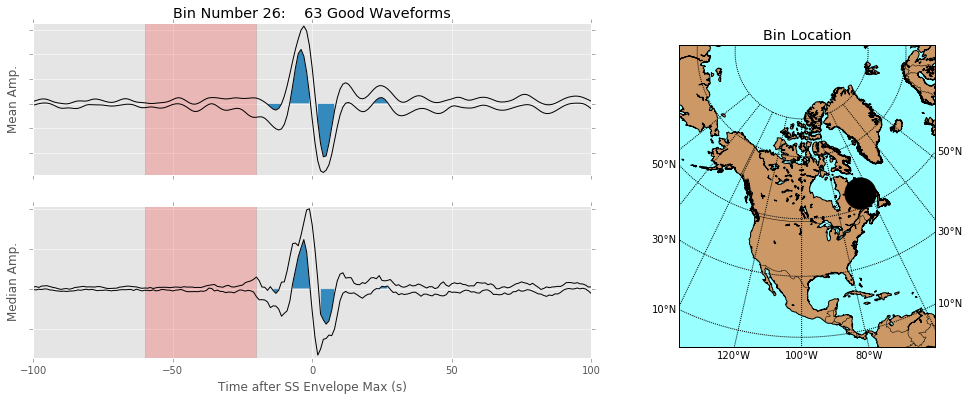

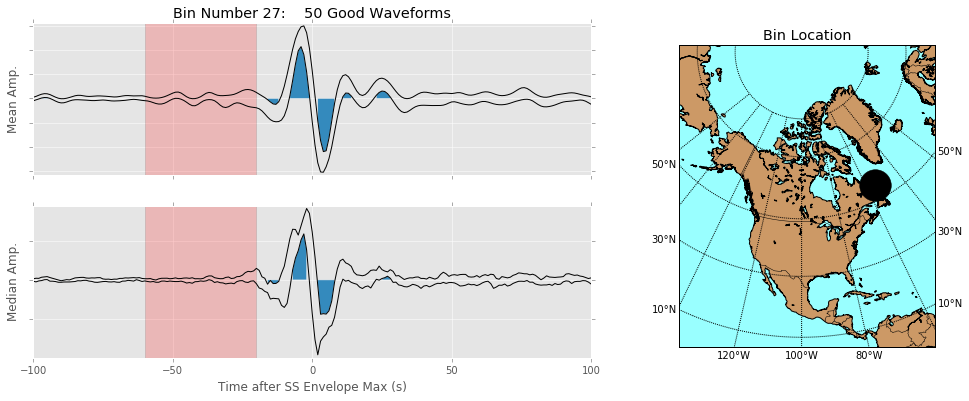

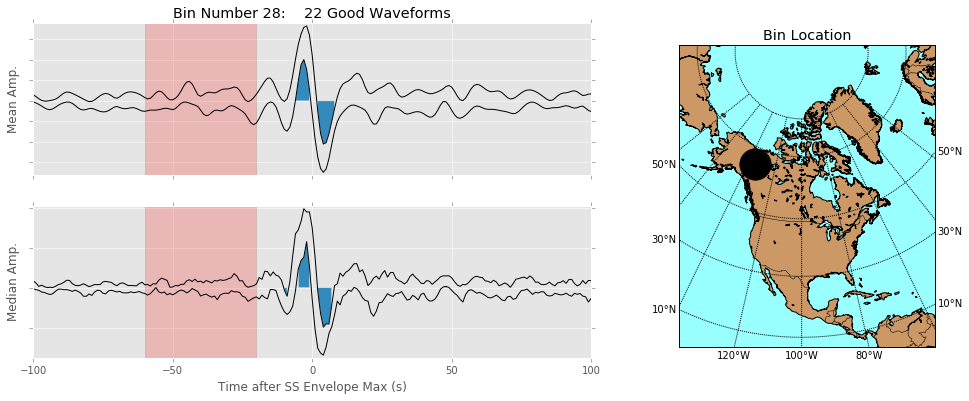

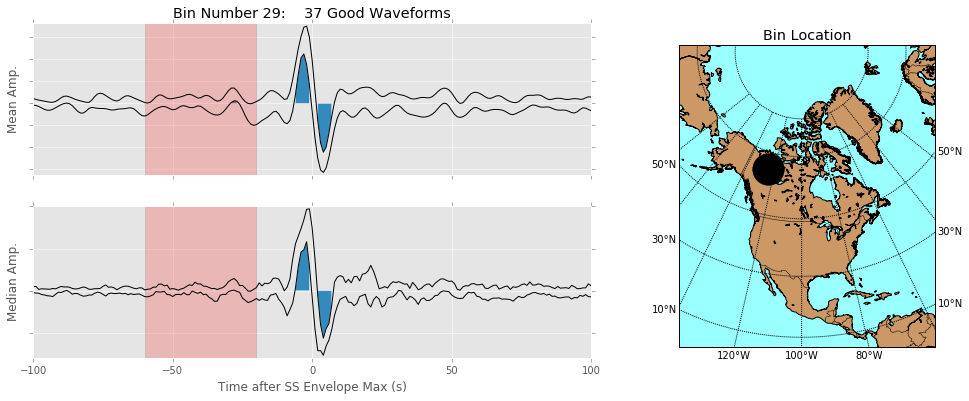

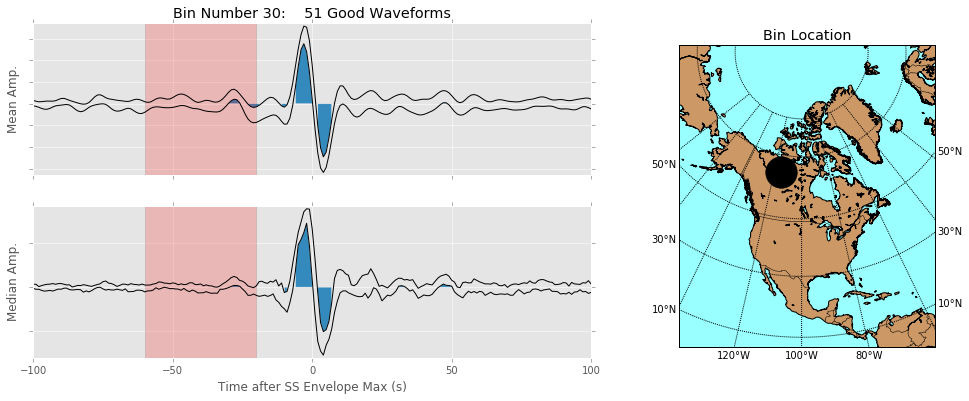

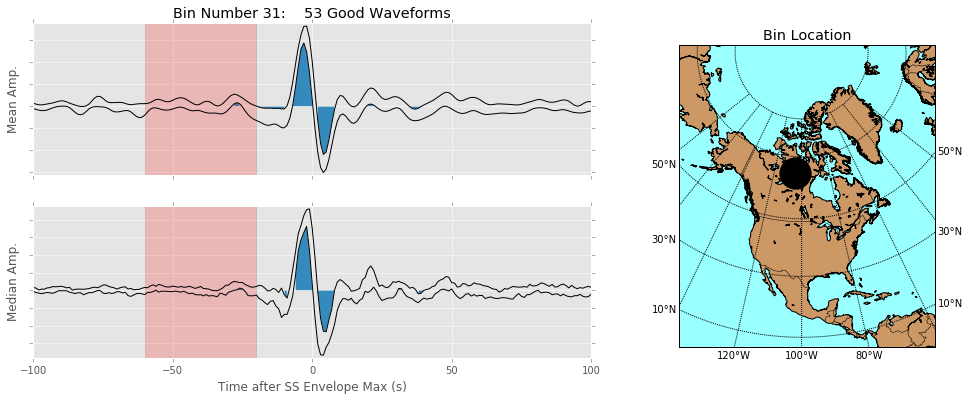

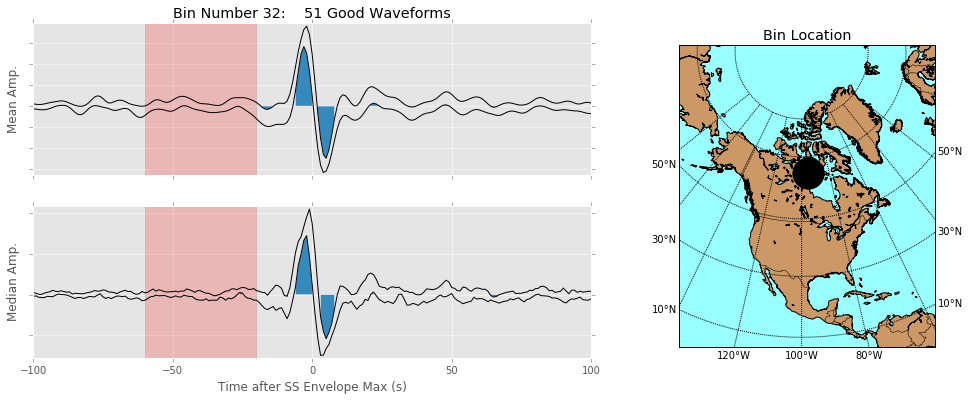

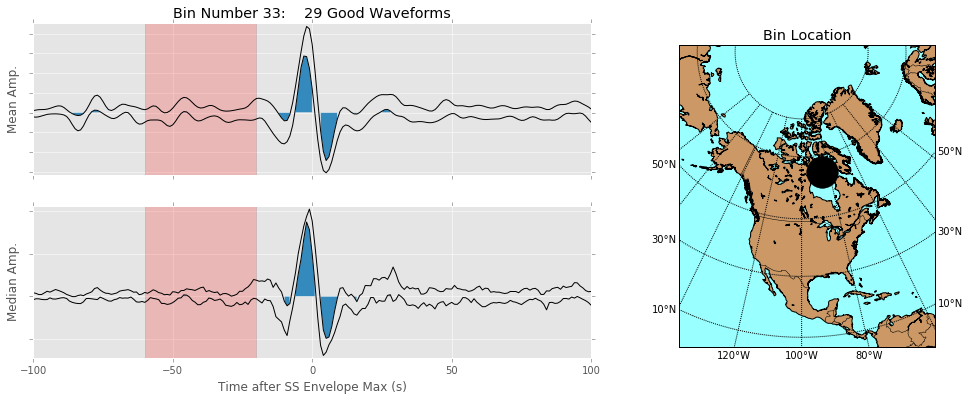

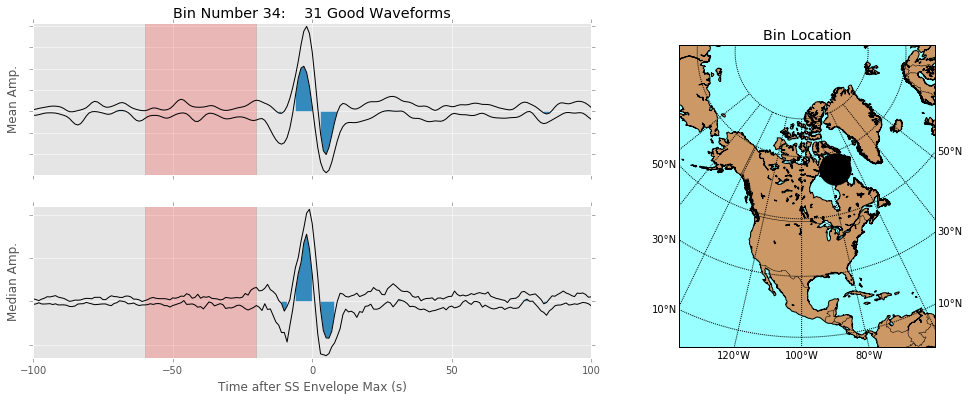

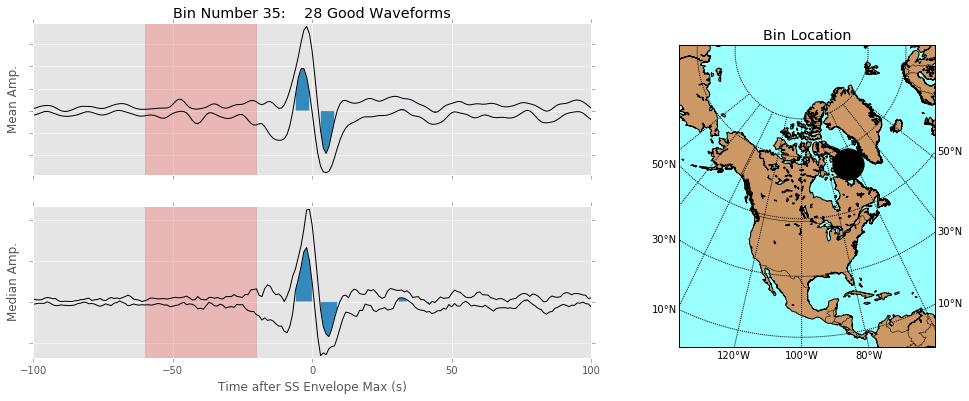

Skipping bin  36


In [104]:
import obspy
from matplotlib import pylab as plt
from numpy import zeros, argmax, nan, sign, arange
from obspy.signal.filter import envelope
from scipy.signal import hilbert

from numpy import nanmean, nanmedian, nanstd, nanmin, nanmax
from numpy.random import choice

for bin_number in sorted(dfds.BinNumber.unique()):
    dfbin = dfds.query("BinNumber == %d" % bin_number)

    st = obspy.Stream()
    
    npts = 800
    
    ngood = 0

    rbin = zeros(npts*len(dfbin)).reshape(npts,len(dfbin)) + nan

    for ii, row in enumerate(dfbin.iterrows()):
        bpindex = row[1].ID_Full
        directory = 'data/mseed/%s/' % row[1].Event
        filename = directory + bpindex + '.mseed'
        st0 = obspy.read(filename).detrend().taper(0.05)
        #st0.filter('bandpass',freqmin=0.01,freqmax=0.1,corners=4)
        st0.filter('lowpass',freq=0.1,corners=4,zerophase=True)
        tr = st0[0]
        tr.data = hilbert(tr.data).imag
        imax = argmax(abs(envelope(tr.data)))
        norm = sign(tr.data[imax])*envelope(tr.data)[imax]
        if imax < 195 or imax > 240:    
            continue
        else:
            ngood += 1
        ishift = int(npts/2 - imax)
        rbin[ishift:ishift+len(tr.data),ii] = hilbert(-tr.data).imag/norm
        #rbin[ishift:ishift+len(tr.data),ii] = tr.data/norm

    #plt.imshow(rbin,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    
    if ngood < 10:
        print('Skipping bin %3d' % bin_number)
        continue

    fig = plt.figure(1,figsize=(10,6))


    nboot = 100
    bbin = zeros(800*nboot*2).reshape(800,nboot,2) + nan

    for iboot in range(nboot):
        random_sample = choice(range(len(dfbin)), size = len(dfbin))
        bbin[:,iboot,0] = nanmean(  rbin[:,random_sample],axis=1)
        bbin[:,iboot,1] = nanmedian(rbin[:,random_sample],axis=1)

    for itype in [0,1]:
        plt.subplot(2,1,itype+1)
        
        plt.fill([-60,-60,-20,-20], [-2,2,2,-2], 'r', alpha=0.2, edgecolor='k')
        
        fmin=nanmean(bbin[:,:,itype],axis=1)-2.*nanstd(bbin[:,:,itype],axis=1)
        fmax=nanmean(bbin[:,:,itype],axis=1)+2.*nanstd(bbin[:,:,itype],axis=1)

        times = arange(len(fmin))*tr.stats.delta-npts/2

        #plt.plot(nanmean(bbin,axis=1))
        plt.plot(times,fmax,'k')
        plt.plot(times,fmin,'k')
        plt.fill_between(times,0,fmin, where=fmin>0)
        plt.fill_between(times,fmax,0, where=fmax<0)

        buf=1.04

        plt.ylim(nanmin(fmin)*buf,nanmax(fmax)*buf)
        plt.xlim(-100,+100)
        plt.gca().set_yticklabels([])
        
        if itype == 0:
            plt.title('Bin Number %2d: %5d Good Waveforms' % (bin_number, ngood))
            plt.gca().set_xticklabels([])
            plt.ylabel('Mean Amp.')
        else:
            plt.xlabel('Time after SS Envelope Max (s)')
            plt.ylabel('Median Amp.')
        
    
    
    ax = fig.add_axes([0.95, 0.15, 0.5, 0.7])
    plot_location(bin_number)
    
    plt.show()

**Notes**: Red shading indicates expected time window for LAB/MLD phases.  Schmerr's method indeed helps avoid the sidelobe issue, but single phases are antisymmetric pulses which makes the smaller ones difficult to pick out and assign appropriate polarity.